In [65]:
from ga.ga_hlm import *
from hlm_basic.ssn import GenerateNetwork, UpstreamArea
from hlm_basic.watershed import Watershed
from hlm_basic.tools import GetForcing, Set_InitialConditions, plot_sim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
from fitness_scenarios import *
import pickle

In [2]:
l_id, connectivity, h_order, nextlink = GenerateNetwork(5)
n_hills = len(connectivity)
a_hill = 0.5 * 0.5 #km2
A_h = np.array([a_hill*10**6 for i in range(n_hills)]) #m2
L_i = np.array([0.5*10**3 for i in range(n_hills)])  #m
A_i = UpstreamArea(a_hill, connectivity, h_order) #km2

In [3]:
forcing, raw_data = GetForcing("../data/rainfall/2010_timeseries.csv", '2010-06-01','2010-08-01')
te = len(forcing)-1

In [4]:
dams = [9,27,36,45,63,90,108,117,126,135,144,153,171,189,198,207,216,225,234] 
order_3 = [9,36,45,63,90,117,126,144,153,171,198,207,225,234] 
order_4 = [27, 189, 216, 135, 108]
n_dams = len(dams)
# Parameters of each dam (For Model 256)
_alpha = [0.5 for _ in range(n_dams)]
c1 = [0.6 for _ in range(n_dams)]
c2 = [3.0 for _ in range(n_dams)]

H_spill = []
H_max = []
diam = []
S_max = []
L_spill = []
L_crest = []
for dam in dams:
    if dam in order_3:
        H_spill.append(4.5)
        H_max.append(5)
        diam.append(1.0)
        S_max.append(200000)
        L_spill.append(2.0)
        L_crest.append(5.0)
    elif dam in order_4:
        H_spill.append(4.5)
        H_max.append(5.0)
        diam.append(1.0)
        S_max.append(300000)
        L_spill.append(4.0)
        L_crest.append(10.0)
        

In [5]:
SSN1 = Watershed(Model=254)
SSN1.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
SSN1.initialize(q=q, s_p=s_p, s_t=s_t, s_s=s_s)
dc_nodam = SSN1.Run_254( [0, te],forcing, rtol=1e-6,)

Model 254 is being used!
87839

In [6]:
SSN3 = Watershed(Model=256)
SSN3.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN3.dam_ids = dams
dam_params256 = SSN3.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]
SSN3.set_dam_state(states=[1 for _ in range(n_dams)])
SSN3.initialize(q=q, S = S, s_t =s_t, s_p =s_p, s_s=s_s)

dc_passive, st_passive = SSN3.Run_256( [0, te], forcing, dam_params256)

Model 256 (254 with_dams) is being used!
87839

In [6]:
def RunSimulation(args):
    ''' Used to run simulation for a given initial time and lead time.
        Output is used to calculate fitness function
    parameters:
        args:list, includes "Watershed" object, t0, forcing, dam_parameters, t_next(lead_time)
    '''

    object, state , t0, forcing, dam_parameters, t_next = args
    object.set_dam_state(states=state)
    discharge, storage = object.Run_256( [t0, t0+t_next], forcing, dam_parameters)
    flow_max = discharge.max(axis=0)
    volume_max = storage.max(axis=0)
    return [flow_max, volume_max]

In [84]:
# watershed object initialization
SSN5 = Watershed(Model=256)
SSN5.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN5.dam_ids = dams
dam_params256 = SSN5.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]
# continuous simulation
te=180
update = 60 #mins
lead_time = 60 # the time window used in optimization procedure 
lead_time2 = 60 # the time window checked if there will be any flooding 
t0 = 0
states_all = []
columns = SSN5.__columns__()
dc_ga = pd.DataFrame(columns =columns[0])
st_ga  = pd.DataFrame(columns =columns[1])
while t0 < te-lead_time2:
    if t0 !=0:
        q, S, s_p, s_t, s_s = SSN5.Get_Snapshot()
    
    #define initial conditions
    SSN5.initialize(q=q, S=S, s_p=s_p,s_t =s_t, s_s=s_s)
    #check if flooding occurs
    data = RunSimulation([SSN5,[1 for _ in range(n_dams)] , t0, forcing, dam_params256, lead_time2])
    flow = data[0]

    if flow['8']>31.80/2 or flow['26']>30.40/2 or flow['62']>27.4/2 or flow['89']>16.33/2 or flow['170']>16.33/2:

        population = InitialPopulation2(16, n_dams)
        fitness_all = []
        generation = 0
        while generation<10: # generation
            results = []
            for dam_state in population:
                sim= RunSimulation([SSN5, dam_state , t0, forcing, dam_params256,lead_time])              
                results.append(sim)
            state_previous = states_all[-1][1]
            fitnesses = FitnessCalculator_Scenario_5(results, population, state_previous)
            idx = np.argmax(fitnesses)
            fitness_all.append(fitnesses[idx])
            parents = MatingPoolSelection(population, fitnesses, n_parents=None, selection='best')
            offsprings = Crossover(parents, operator='uniform')        
            offsprings_mutated = MutateOffspring(offsprings, method='scrample', p=0.10)
            population = NewPopulation(parents, offsprings_mutated)
            ##termination
            if generation > 7:
                sub_fitness = fitness_all[-7:]
                if len(set(sub_fitness)) == 1:
                    print(f'[+] Search terminated at generation {generation}')
                    break
            generation +=1
        state = population[idx].astype(float).tolist()
        print('[+]', t0, ' >>> ', state, 'fitness>>', fitnesses[idx])

    else:

        state = [1 for _ in range(n_dams)]
        print(' [-]',t0, ' >>> ', state, )

    states_all.append((t0,state))
    SSN5.set_dam_state(states=state)

    try:
        dc, st = SSN5.Run_256([t0, t0+update], forcing, dam_params256,)
    except IndexError:
        break

    t0 += update
    dc_ga = dc_ga.append(dc)
    st_ga = st_ga.append(st)

Model 256 (254 with_dams) is being used!
 [-] 0  >>>  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[+] 60  >>>  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] fitness>> 0.2846425619890862
120

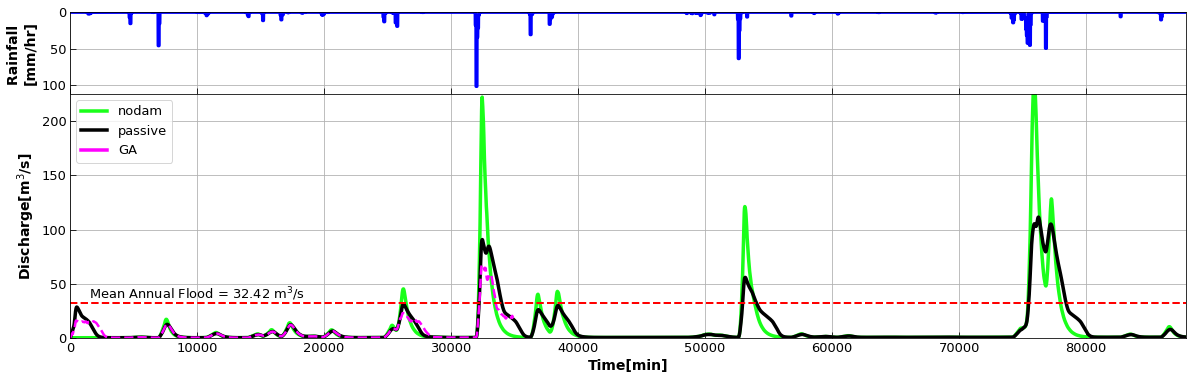

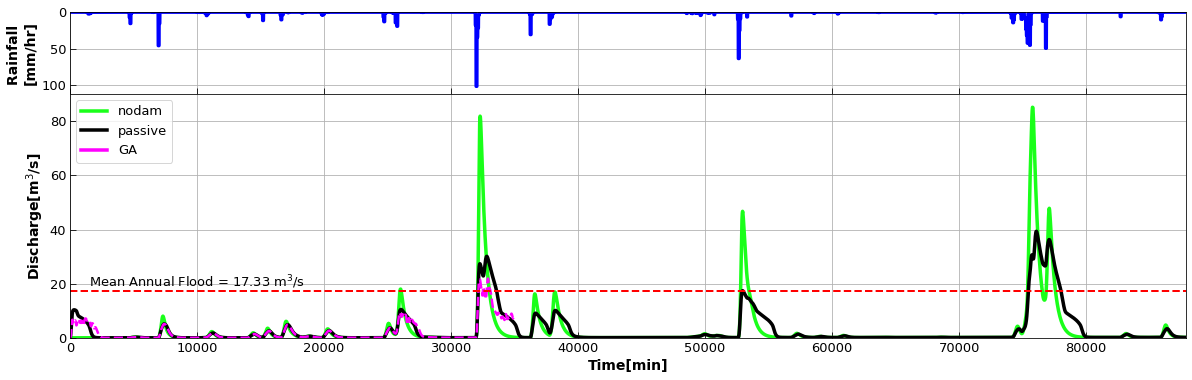

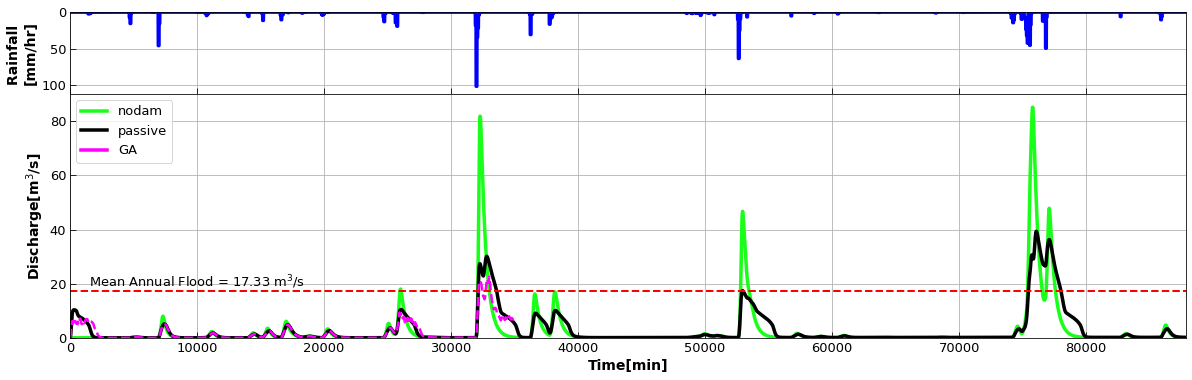

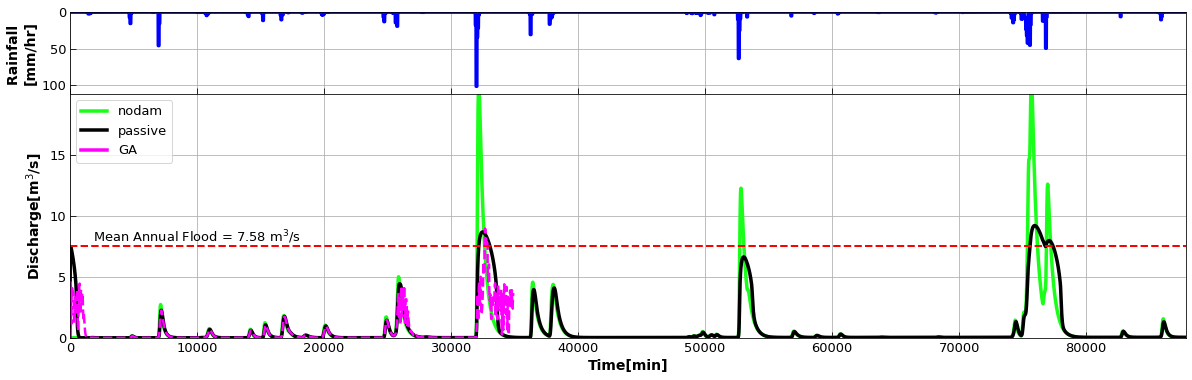

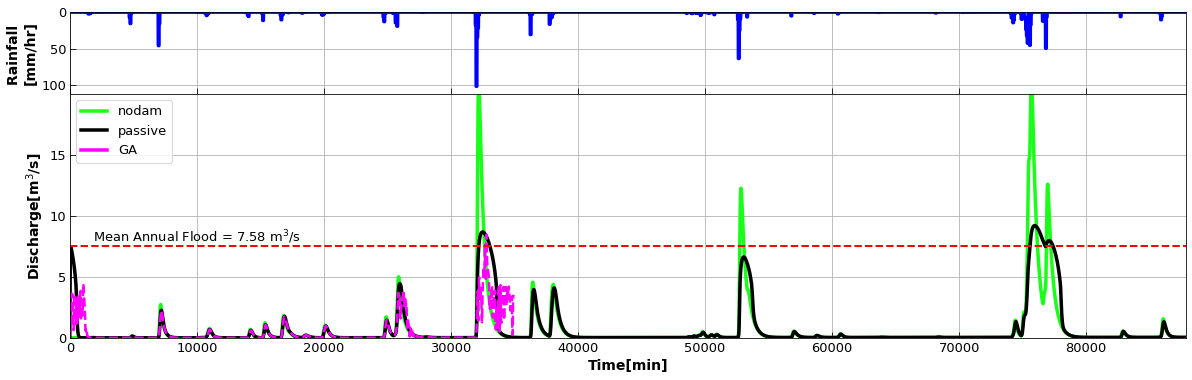

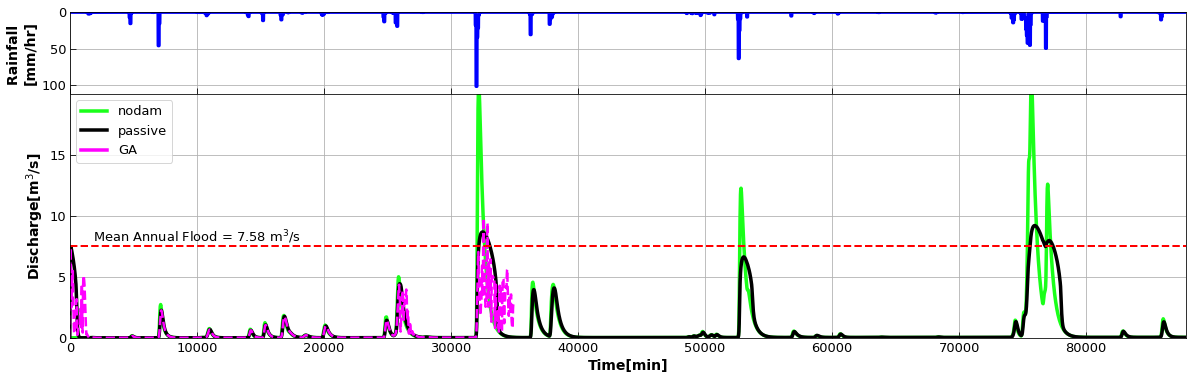

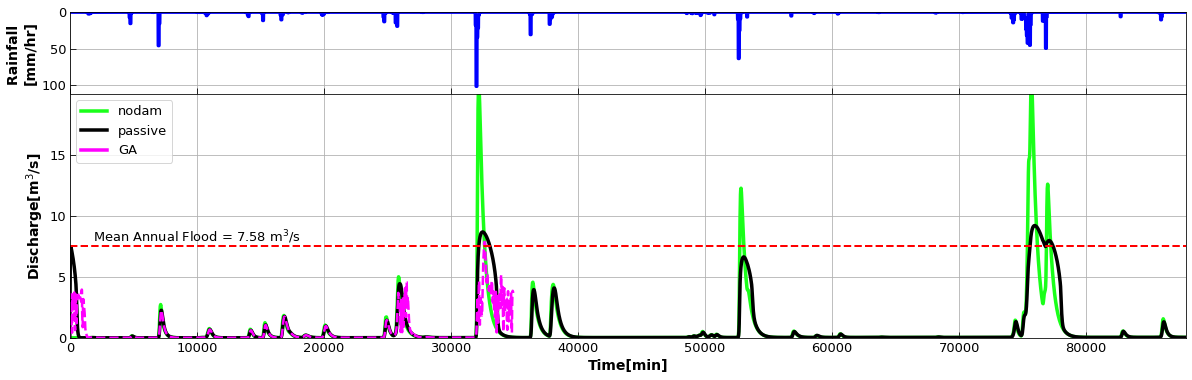

In [22]:
s_name = '_h45_5_O75_1_10_19dams' 
pltkwargs = np.array([{'label':'nodam', 'color':'#1AFF1A'}, {'label':'passive', 'color':'#000000',},{'label':'GA', 'color':'magenta','alpha':1.0, 'linestyle':'dashed', 'linewidth':2.5},{'label':'extra', 'color':'#490092'}])
pltKwargs = pltkwargs[[0,1,2]]
dataset = [dc_nodam, dc_passive, dc_ga]
plot_sim(0, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,225,50], area=60.75)#, save='../../Supp_DamStudy/Hydro0'+s_name)
plot_sim(81, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,90,20], area=20.25)#, save='../../Supp_DamStudy/Hydro81'+s_name)
plot_sim(162, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,90,20], area=20.25)#, save='../../Supp_DamStudy/Hydro81'+s_name)
plot_sim(35, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,20,5], area=4.75,)
plot_sim(197, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,20,5], area=4.75)
plot_sim(224, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,20,5], area=4.75)
plot_sim(143, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,20,5], area=4.75)


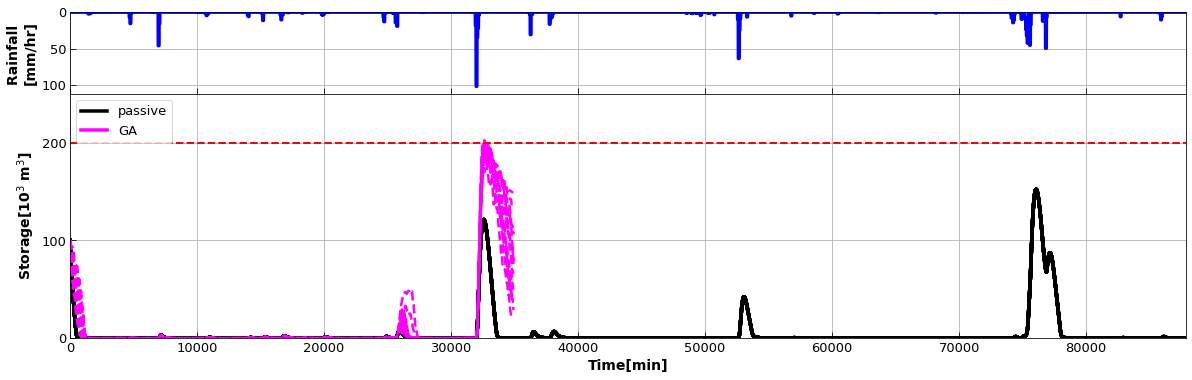

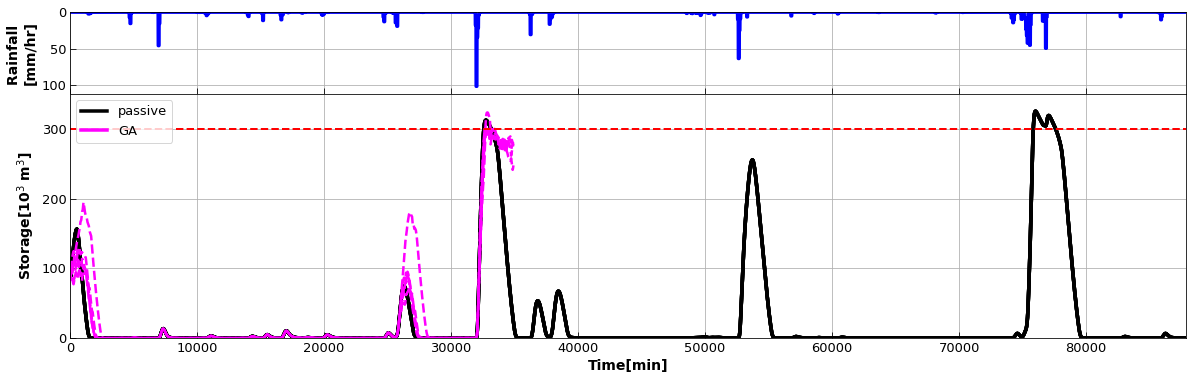

In [23]:
order_3 = [9,36,45,63,90,117,126,144,153,171,198,207,225,234] 
order_4 = [27, 189, 216, 135, 108]
pltKwargs = pltkwargs[[1,2]]
dataset = [ st_passive,st_ga]
plot_sim(order_3, forcing, dataset, pltKwargs, d_type='storage', max_storage=200000)
plot_sim(order_4, forcing, dataset, pltKwargs, d_type='storage', max_storage=300000)

In [83]:
from imp import reload 
import fitness_scenarios
reload(fitness_scenarios)
from fitness_scenarios import *

In [11]:
ss1 = st_passiveVAR[(st_passiveVAR.index>30000)]['27']
ss2 = st_passive[(st_passive.index>30000)]['27']
# ss3 = st_bug[(st_bug.index>30000)]['27']

dd1 = dc_passiveVAR[(dc_passiveVAR.index>30000)]['27']
dd2 = dc_passive[(dc_passive.index>30000)]['27']
# dd3 = dc_bug[(dc_bug.index>30000)]['27']


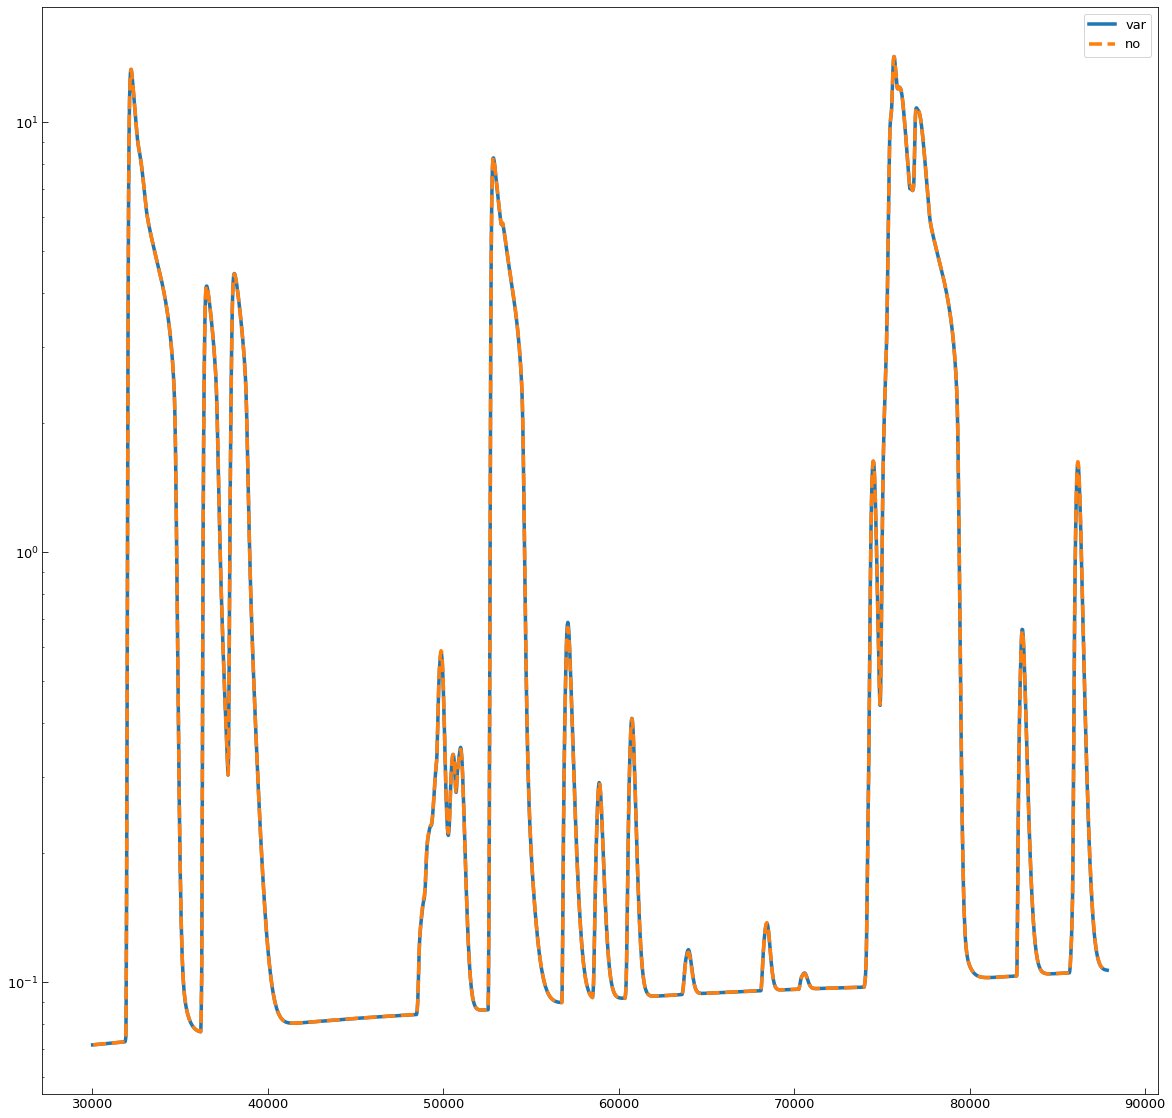

In [12]:
plt.subplots(figsize=(20, 20))
plt.yscale('log')
dd1.plot(label='var')
dd2.plot(label='no', linestyle='dashed')
# dd3.plot(label='no', linestyle='dashdot')

plt.legend()

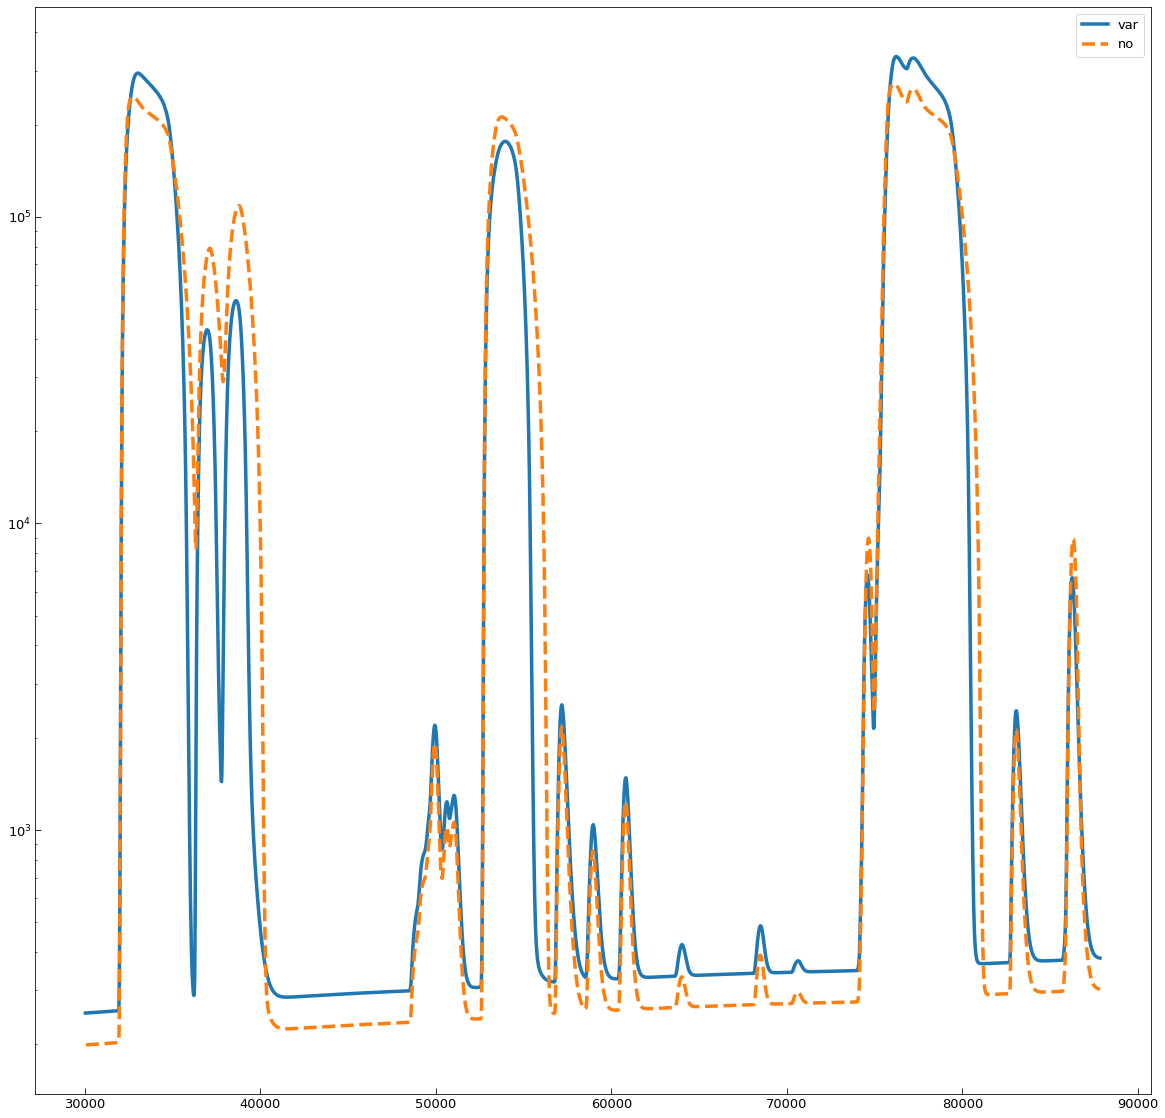

In [13]:
plt.subplots(figsize=(20, 20))
plt.yscale('log')
ss1.plot(label='var')
ss2.plot(label='no', linestyle='dashed')
# ss3.plot(label='5min', linestyle='dashdot')
plt.legend()